In [ ]:
!pip install --quiet yfinance

Portfolio Risk Assessment & 1-Day 95% VaR Calculation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import datetime as dt
from scipy import stats
import yfinance as yf
import time ### this is for fetching our data

sns.set_style('whitegrid') ## provide grid structure
%matplotlib inline

In [ ]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
weights = np.array([0.25,0.25,0.25,0.25])

start = dt.datetime(2020,1,1)
end = dt.datetime.today()

price = pd.DataFrame(index=pd.date_range(start, end))
print(price)

Empty DataFrame
Columns: []
Index: [2020-01-01 00:00:00, 2020-01-02 00:00:00, 2020-01-03 00:00:00, 2020-01-04 00:00:00, 2020-01-05 00:00:00, 2020-01-06 00:00:00, 2020-01-07 00:00:00, 2020-01-08 00:00:00, 2020-01-09 00:00:00, 2020-01-10 00:00:00, 2020-01-11 00:00:00, 2020-01-12 00:00:00, 2020-01-13 00:00:00, 2020-01-14 00:00:00, 2020-01-15 00:00:00, 2020-01-16 00:00:00, 2020-01-17 00:00:00, 2020-01-18 00:00:00, 2020-01-19 00:00:00, 2020-01-20 00:00:00, 2020-01-21 00:00:00, 2020-01-22 00:00:00, 2020-01-23 00:00:00, 2020-01-24 00:00:00, 2020-01-25 00:00:00, 2020-01-26 00:00:00, 2020-01-27 00:00:00, 2020-01-28 00:00:00, 2020-01-29 00:00:00, 2020-01-30 00:00:00, 2020-01-31 00:00:00, 2020-02-01 00:00:00, 2020-02-02 00:00:00, 2020-02-03 00:00:00, 2020-02-04 00:00:00, 2020-02-05 00:00:00, 2020-02-06 00:00:00, 2020-02-07 00:00:00, 2020-02-08 00:00:00, 2020-02-09 00:00:00, 2020-02-10 00:00:00, 2020-02-11 00:00:00, 2020-02-12 00:00:00, 2020-02-13 00:00:00, 2020-02-14 00:00:00, 2020-02-15 00:00:00

In [ ]:
for ticker in tickers:
  print(f"Fetching {ticker}", end="")
  try:
    #fetching the data
    df=yf.ticker(ticker).history(
        start=start.strftime("%Y-%m-%d"),
        end=end.strftime("%Y-%m-%d"),
        auto_adjust=True,
        )
    series=df['close']
    print("Y finance ",end="")
  except Exception as e:
    print(f"X yfinance ({e}); falling back to Stooq")
    df2=pdr.DataReader(ticker,'stooq',start,end)
    series=df2['Close']
  price[ticker]=series
  time.sleep(1)
prices=price.dropna(how="all").ffill().bfill()
print(prices.tail())

Fetching AAPLX yfinance ('module' object is not callable); falling back to Stooq
Fetching MSFTX yfinance ('module' object is not callable); falling back to Stooq
Fetching GOOGLX yfinance ('module' object is not callable); falling back to Stooq
Fetching AMZNX yfinance ('module' object is not callable); falling back to Stooq
              AAPL    MSFT   GOOGL    AMZN
2025-05-16  211.26  454.27  166.19  205.59
2025-05-19  208.78  458.87  166.54  206.16
2025-05-20  206.86  458.17  163.98  204.07
2025-05-21  202.09  452.57  168.56  201.12
2025-05-22  201.36  454.86  170.87  203.10


In [ ]:
# log-return = ln(P_t / P_{t-1})
logr = np.log(prices / prices.shift(1)).dropna()
logr.head()

,AAPL,MSFT,GOOGL,AMZN
2020-01-03,-0.009737,-0.012360,-0.005243,-0.012213
2020-01-06,0.007879,0.002580,0.026304,0.014776
2020-01-07,-0.004666,-0.009299,-0.001935,0.002089
2020-01-08,0.015943,0.016008,0.007094,-0.007839
2020-01-09,0.021054,0.012240,0.010441,0.004788


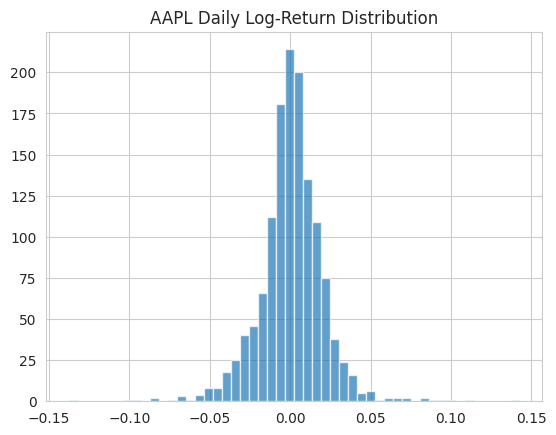

In [ ]:
# Plot one example series for visual Check
#You'll see a bell-shaped histogram.
logr['AAPL'].hist(bins=50, alpha=0.7)
plt.title('AAPL Daily Log-Return Distribution')
plt.show()

In [ ]:
summary= pd.DataFrame({
    'Mean':logr.mean(),
    'Variance': logr.var(),
    'Skewness':logr.skew(),
    'Kurtosis':logr.kurtosis()
    })
summary

,Mean,Variance,Skewness,Kurtosis
AAPL,0.000752,0.000425,0.020390,6.226807
MSFT,0.000802,0.000372,-0.164616,7.430717
GOOGL,0.000678,0.000431,-0.227661,3.636135
AMZN,0.000562,0.000524,-0.069501,4.160446


In [ ]:
mu_norm = logr.stack().mean()
sigma_norm = logr.stack().std(ddof=1)

# 95% CI for mean under Normal: u ± z * σ / √N
N = logr.size
z95 = stats.norm.ppf(0.975)
ci_mu_norm = (mu_norm - z95 * sigma_norm / np.sqrt(N),
              mu_norm + z95 * sigma_norm / np.sqrt(N))

# 95% CI for σ via Chi-square:
df = N - 1
chi2_low, chi2_high = stats.chi2.ppf([0.025, 0.975], df)
ci_sigma_norm = (sigma_norm * np.sqrt(df / chi2_high),
                 sigma_norm * np.sqrt(df / chi2_low))

print("Normal fit:")
print(f"μ = {mu_norm:.5f}, 95% CI {ci_mu_norm}")
print(f"σ = {sigma_norm:.5f}, 95% CI {ci_sigma_norm}")


Normal fit:
μ = 0.00070, 95% CI (np.float64(0.00014135581013294892), np.float64(0.0012558400131748955))
σ = 0.02092, 95% CI (np.float64(0.02053681862658147), np.float64(0.02132521057520147))


In [ ]:
#4.2 Fit Student's t
#Fit t-distribution to the pooled returns
#returns_flat = all asset returns concatenated
returns_flat = logr.stack().values
df_t, mu_t, sigma_t = stats.t.fit(returns_flat)
print(df_t)
print(mu_t)

3.6546646101861917
0.0010493773461387728


In [ ]:
# 95% CI for p and gof a t-fit is more complex; we can bootstrap them:
B = 1000
estimates = np.array([stats.t.fit(np.random.choice(returns_flat, size=N, replace=True))
                      for _ in range (B)])
ci_mu_t = np.percentile(estimates[:,1], [2.5, 97.5])
ci_sigma_t = np.percentile(estimates[:,2], [2.5, 97.5])

print("\nstudent's t fit:")
print(f" df = {df_t: 1f}, μ = {mu_t:.5f}, σ = {sigma_t:.5f}")
print(f" 95% CI for μ (bootstrap): {ci_mu_t}")
print(f" 95% CI for σ (bootstrap): {ci_sigma_t}")


student's t fit:
 df =  3.654665, μ = 0.00105, σ = 0.01447
 95% CI for μ (bootstrap): [0.00056407 0.00147143]
 95% CI for σ (bootstrap): [0.01397033 0.01494488]


1-Day 95% VaR

In [ ]:
portr = logr.dot(weights)
portr

,0
2020-01-03,-0.009888
2020-01-06,0.012885
2020-01-07,-0.003453
2020-01-08,0.007801
2020-01-09,0.012131
...,...
2025-05-16,0.004292
2025-05-19,0.000785
2025-05-20,-0.009112
2025-05-21,-0.005660


In [ ]:
μ_p = portr.mean()
σ_p = portr.std(ddof=1)
print(μ_p)
print(σ_p)

0.0006985979116539223
0.01816307307599588


In [ ]:
z05 = stats.norm.ppf(0.05)
print(z05)

-1.6448536269514729


In [ ]:
VaR_norm = -(μ_p + z05 * σ_p)
print(VaR_norm)

0.02917699871398255


In [ ]:
# using student-t distribution
t05= stats.t.ppf(0.05, df_t)
print(t05)

-2.1910631681901496


In [ ]:
VaR_t = -(mu_t + sigma_t * t05) *1
print(VaR_t)

0.03065396154289155


In [ ]:
# Historical method
hist_VaR = -np.percentile(portr, 5)
print(hist_VaR)

0.028926594256303912


In [ ]:
print("1-Day 95% VaR: ")
print(f"Parametric (Normal): {VaR_norm:.5f}")
print(f"Parametric (Student's t): {VaR_t:.5f}")
print(f"Historical (5th percentile): {hist_VaR:.5f}")

1-Day 95% VaR: 
Parametric (Normal): 0.02918
Parametric (Student's t): 0.03065
Historical (5th percentile): 0.02893


We found that on most days portfolio won't lost more than 2.9 to 3.1%

Hypothesis Test

In [ ]:
t_stat, p_val = stats.ttest_1samp(portr, 0.0)
print("One sample t-test on portfolio daily returns: ")
print(f"t-statistic: {t_stat:.5f}")
print(f"p-value: {p_val:.5f}")

One sample t-test on portfolio daily returns: 
t-statistic: 1.41530
p-value: 0.15721


In [ ]:
if p_val < 0.05:
  print(" ->  Reject the null hypothesis, mean return is significantly different from zero.")
else:
  print(" ->  Fail to reject the null hypothesis, no evidence - mean return not equal to zero. ")

 ->  Fail to reject the null hypothesis, no evidence - mean return not equal to zero. 


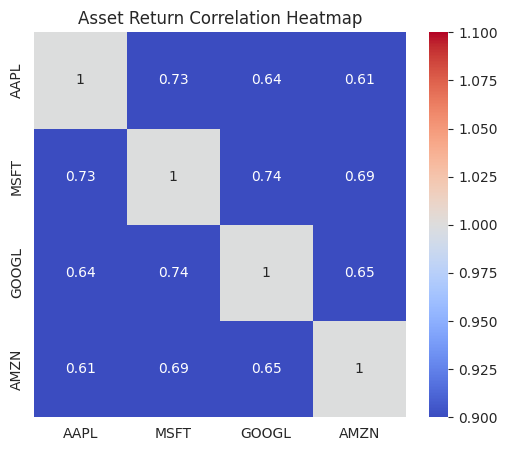

In [ ]:
# Correalation and diversification benefits
import seaborn as sns

# a) Correlation heatmap
corr = logr.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=1, vmax=1)
plt.title('Asset Return Correlation Heatmap')
plt.show()

#b)
#sigma_i = logr.std()
#sigma_weighted = np.dot(weights, sigma_i)
#sigma_portfolio = sigma_p
#print(f"Weighted avg sigma: {sigma_weighted:.4f}")
#print(f"Actual Portfolio: {sigma_portfolio:.4f}")
#print(f"Diversification benefit: {sigma_weighted-sigma_portfolio:.4f}")

In [ ]:
cum_ret = (price / price.iloc[0]).prod(axis=1)
cum_ret

,0
2020-01-01,1.0
2020-01-02,1.0
2020-01-03,1.0
2020-01-04,1.0
2020-01-05,1.0
...,...
2025-05-19,1.0
2025-05-20,1.0
2025-05-21,1.0
2025-05-22,1.0


In [ ]:
cum_port = (portr + 1).cumprod()
cum_port

,0
2020-01-03,0.990112
2020-01-06,1.002869
2020-01-07,0.999406
2020-01-08,1.007203
2020-01-09,1.019421
...,...
2025-05-16,2.074619
2025-05-19,2.076247
2025-05-20,2.057330
2025-05-21,2.045685


In [ ]:
#track the highest values so far
rolling_max = cum_port.cummax()
drawdown = (cum_port - rolling_max) / rolling_max

In [ ]:
max_dd = drawdown.min()
print(f"Maximum drawdown: {max_dd:.5f}")

end_date = drawdown.idxmin()
print(f"Date of maximum drawdown: {end_date}")

start_date = cum_port[:end_date].idxmax()
print(f"Date of maximum drawdown recovery: {start_date}")

print(f"\nFrom {start_date.date()} to {end_date.date()}")

Maximum drawdown: -0.43979
Date of maximum drawdown: 2023-01-05 00:00:00
Date of maximum drawdown recovery: 2021-12-10 00:00:00

From 2021-12-10 to 2023-01-05


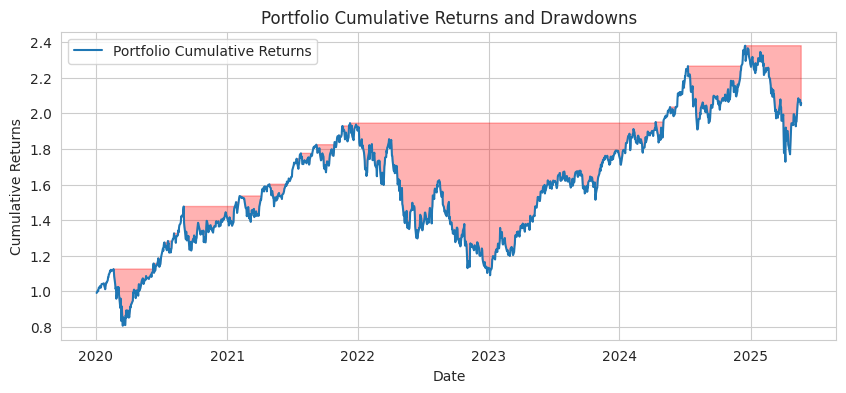

In [ ]:
#plot
plt.figure(figsize=(10,4))
plt.plot(cum_port, label='Portfolio Cumulative Returns')
plt.fill_between(drawdown.index, cum_port, rolling_max,
                 where = drawdown<0, color='red', alpha=0.3)
plt.title('Portfolio Cumulative Returns and Drawdowns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

Expected Shortfall (CVaR)

In [ ]:
alpha = 0.5 #ES beyond 95%

#Historical
ES_historical = portr[portr <= np.percentile(portr, 5)].mean()
print(f"Historical ES (95%): {ES_historical:.5f}")

#Normal
ES_norm = (μ_p - σ_p * stats.norm.pdf(z05)/ alpha)
print(f"Normal ES (95%): {ES_norm:.5f}")


Historical ES (95%): -0.04230
Normal ES (95%): -0.00305


VaR Backtesting

In [ ]:
var_series = -(portr.rolling(1).mean() + portr.rolling(1).std()*z05)
# For simplicity use constant VaR_norm
exceptions = portr < -VaR_norm
num_exc = exceptions.sum()
total = len(portr)
print(f"Exceptions: {num_exc}/{total} days ({num_exc/total:.2%}, expected ~5%)")

Exceptions: 67/1354 days (4.95%, expected ~5%)


Rolling 60-day VaR

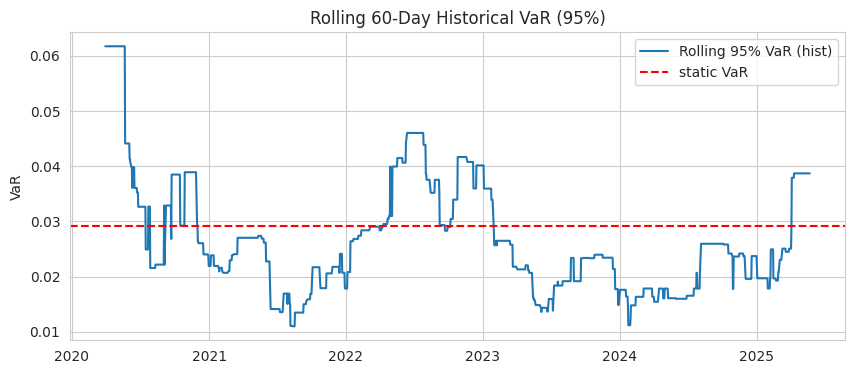

In [ ]:
window = 60
roll_var = portr.rolling(window).quantile(0.05).dropna()
plt.figure(figsize = (10,4))
plt.plot(-roll_var, label='Rolling 95% VaR (hist)')
plt.axhline(VaR_norm, color='red', linestyle='--', label='static VaR')
plt.title('Rolling 60-Day Historical VaR (95%)')
plt.ylabel('VaR')
plt.legend()
plt.show()

Jarque-Bera Normality Test

In [ ]:
jb_start, jb_p = stats.jarque_bera(portr)
print(f"JB statistic: {jb_start:.2f}")
print(f"p-value: {jb_p:.3f}")

if jb_p < 0.05:
  print("->  Reject the normality at 5% level.")
else:
  print("->  Cannot reject normality.")

JB statistic: 1191.65
p-value: 0.000
->  Reject the normality at 5% level.


ASSIGNMENT QUESTIONS:

**Question - 1:**

Given a portfolio’s VaR at 95% confidence is 10,000, compute the Expected Shortfall (ES)
if the tail loss distribution follows a normal distribution.

In [ ]:
# VaR at 95% confidence is 10,000
# The formula for Expected Shortfall (ES) for a normal distribution is:
# ES = μ - σ * (φ(z_α) / α)
# where:
# μ is the mean return
# σ is the standard deviation of returns
# φ is the probability density function (PDF) of the standard normal distribution
# z_α is the α-th quantile of the standard normal distribution (where α is the confidence level, e.g., 0.05 for 95% VaR/ES)
# α is the significance level (1 - confidence level, so 0.05 for 95%)

# Recalculate ES using the normal distribution formula with the parameters from the data

alpha = 0.05 # Significance level for 95% confidence
pdf_at_z05 = stats.norm.pdf(z05)

ES_norm_calculated = -(μ_p - σ_p * (pdf_at_z05 / alpha))
print(f"\nCalculated ES (95%) assuming Normal Distribution based on portfolio data: {ES_norm_calculated:.5f}")

#print("\nAssuming the question asks for the Expected Shortfall percentage based on the fitted normal distribution:")
print(f"Expected Shortfall (ES) at 95% Confidence (Normal Distribution assumption): {-ES_norm_calculated * 100:.5f}%")

print("\nCorrected calculation for Normal ES using alpha = 0.05:")
print(f"Normal ES (95%): {ES_norm_calculated:.5f}")
print(f"Normal ES (95% as a positive loss percentage): {-ES_norm_calculated:.5f}")


Calculated ES (95%) assuming Normal Distribution based on portfolio data: 0.03677
Expected Shortfall (ES) at 95% Confidence (Normal Distribution assumption): -3.67666%

Corrected calculation for Normal ES using alpha = 0.05:
Normal ES (95%): 0.03677
Normal ES (95% as a positive loss percentage): -0.03677


**Conclusion:**

The analysis concludes with calculating the Expected Shortfall (ES) for the portfolio assuming a normal distribution for losses.

When the market is really bad (worse than 95% of days), the average loss we expect for this portfolio is about 3.68%. This is the "Expected Shortfall".

The "Value at Risk" (VaR) tells us the most we expect to lose on 95% of days, but the Expected Shortfall tells us what the average loss is when we lose more than the VaR.

**Question - 2:**

A portfolio has an expected annual return of 12%, a risk-free rate of 2%, and a standard
deviation of 18%. Compute the Sharpe Ratio.

In [ ]:
expected_annual_return = 0.12  # 12%
risk_free_rate = 0.02    # 2%
annual_std_dev = 0.18    # 18%

sharpe_ratio = (expected_annual_return - risk_free_rate) / annual_std_dev
print(f"The Sharpe Ratio is: {sharpe_ratio:.4f}")

The Sharpe Ratio is: 0.5556


**Conclusion:**

Higher Sharpe Ratio is Better:
A higher score means you're getting more return for each unit of risk you're taking.

Lower Sharpe Ratio is not as Good:
A lower score means you're taking more risk for the amount of return you're getting.

A Sharpe Ratio of 0.5556 means you are getting a return of 0.5556 units above that risk-free rate.
We want this number to be as high as possible while comparing.

**Question - 3**

Given mean return = 7%, volatility = 12%, and time horizon = 1 year, simulate one
possible future portfolio return using a Monte Carlo model.

In [ ]:
mean_return = 0.07  # 7%
volatility = 0.12   # 12%
time_horizon = 1    # 1 year

simulated_return = np.random.normal(loc=mean_return, scale=volatility)

print(f"One possible simulated portfolio return over 1 year: {simulated_return:.4f}")

One possible simulated portfolio return over 1 year: -0.0381


**Conclusion:**

Based on this single simulation, the portfolio might actually lose money over 1 year, specifically about 3.81%.
This is just one possibility out of many because the return is random, based on the average expected return and how much the returns typically jump. Some simulations would show gains, others losses, depending on this randomness.